In [ ]:
import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/ML_trace_predictor/')

In [ ]:
import perceptron
import features as f
import numpy as np

In [ ]:

history_length = 4
num_of_classes = 16
ifthenelse_filepath  = '/content/drive/My Drive/ML_trace_predictor/datafiles/ifthenelse/predictionAccuracy.csv'
#libquantum_filepath  = 'datafiles/libquantum/predictionAccuracy.csv'
libquantum_filepath  = '/content/drive/My Drive/ML_trace_predictor/datafiles/short_libquantum/predictionAccuracy.csv'
nested_filepath      = '/content/drive/My Drive/ML_trace_predictor/datafiles/nested/predictionAccuracy.csv'
consecutive_filepath = '/content/drive/My Drive/ML_trace_predictor/datafiles/consecutive/predictionAccuracy.csv'

#no encoding
consecutive_no_features, consecutive_no_labels = f.generateTraceFeaturesWithoutTransform(consecutive_filepath, history_length, num_of_classes)
print ("Integer encoded features: ", consecutive_no_features.shape, " Labels: ", consecutive_no_labels.shape)

#bincode encoding
consecutive_bincode_features, consecutive_bincode_labels = f.generateBincodeTraceFeatures(consecutive_filepath, history_length, num_of_classes)
print ("Binary encoded features: ", consecutive_bincode_features.shape, " Labels: ", consecutive_bincode_labels.shape)

#one-hot encoding
consecutive_onehot_features, consecutive_onehot_labels = f.generateTraceFeatures(consecutive_filepath, history_length, num_of_classes)
print ("One-hot encoded features: ", consecutive_onehot_features.shape, " Labels: ", consecutive_onehot_labels.shape)

Integer encoded features:  (500496, 4)  Labels:  (500496,)
Binary encoded features:  (500496, 16)  Labels:  (500496,)
One-hot encoded features:  (500496, 64)  Labels:  (500496,)


In [ ]:
def create_model(params,num_of_features,loss_fun,num_classes):
    model=keras.Sequential()
    model.add(keras.layers.Dense(units=num_of_features,activation='relu'))
    for i in range (params['layers']):
        model.add(keras.layers.Dense(units=params["N hidden"],activation='relu'))
        model.add(keras.layers.Dropout(params["dropout"]))
    model.add(keras.layers.Dense(num_classes,activation='softmax'))
    RMSprop=keras.optimizers.RMSprop(learning_rate=params["lr"],decay=params["lrd"])
    model.compile(optimizer= RMSprop,loss=loss_fun,metrics=['accuracy'])
    return model

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]])

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
import matplotlib.pyplot as plt


Epoch 1/100
782/782 - 3s - loss: 1.2521 - accuracy: 0.4639 - val_loss: 1.0943 - val_accuracy: 0.5331 - 3s/epoch - 4ms/step
Epoch 2/100
782/782 - 2s - loss: 1.0498 - accuracy: 0.5158 - val_loss: 0.9192 - val_accuracy: 0.5331 - 2s/epoch - 3ms/step
Epoch 3/100
782/782 - 2s - loss: 0.9317 - accuracy: 0.5203 - val_loss: 0.7888 - val_accuracy: 0.5331 - 2s/epoch - 3ms/step
Epoch 4/100
782/782 - 2s - loss: 0.8188 - accuracy: 0.5320 - val_loss: 0.6552 - val_accuracy: 0.7338 - 2s/epoch - 3ms/step
Epoch 4: early stopping
Test loss: 0.6573803424835205
Test accuracy: 0.7309583425521851
Epoch 1/100
782/782 - 3s - loss: 1.2200 - accuracy: 0.4552 - val_loss: 1.0418 - val_accuracy: 0.5387 - 3s/epoch - 4ms/step
Epoch 2/100
782/782 - 2s - loss: 0.9961 - accuracy: 0.5296 - val_loss: 0.8580 - val_accuracy: 0.5387 - 2s/epoch - 3ms/step
Epoch 3/100
782/782 - 2s - loss: 0.8982 - accuracy: 0.5437 - val_loss: 0.7736 - val_accuracy: 0.6704 - 2s/epoch - 3ms/step
Epoch 4/100
782/782 - 2s - loss: 0.8396 - accuracy:

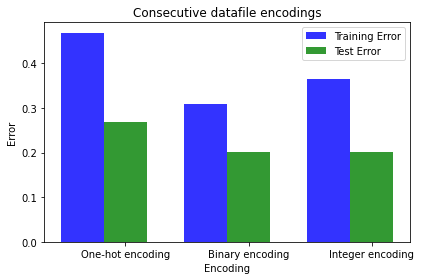

In [ ]:
training_errors = []
test_errors = []
for (features, labels) in ((consecutive_onehot_features, consecutive_onehot_labels), (consecutive_bincode_features, consecutive_bincode_labels), (consecutive_no_features, consecutive_no_labels)):
    indices = np.arange(features.shape[0])
    np.random.shuffle(indices)
    features = features[indices]
    labels = labels[indices].reshape(-1,1)
    encoder = OneHotEncoder(sparse=False)
    encoder.fit(labels)
    training_dataset = features[:int(len(features)*0.05)]
    training_labels = labels[:int(len(labels)*0.05)]
    val_dataset = features[int(len(features)*0.05):int(len(features)*0.1)]
    val_labels = labels[int(len(labels)*0.05):int(len(features)*0.1)]
    test_dataset = features[int(len(features)*0.1):]
    test_labels = labels[int(len(labels)*0.1):]
    training_labels = encoder.transform(training_labels)
    val_labels = encoder.transform(val_labels)
    test_labels = encoder.transform(test_labels)
    _, num_of_features = training_dataset.shape
    params={"lr":0.0001,
       "dropout":0.2,
       "N hidden":5,
       "Mini-batch size":32,
        "lrd":0.0001,
        "layers":2
    }
    model = create_model(params,num_of_features,"categorical_crossentropy",4)
    es=keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=3,min_delta=0.05)
    history = model.fit(training_dataset,training_labels,validation_data=(val_dataset,val_labels),epochs=100,batch_size=params["Mini-batch size"],callbacks=[es], verbose=2)
    
    score = model.evaluate(test_dataset, test_labels, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    training_accuracy=history.history['accuracy'][-1]
    training_errors.append(1-training_accuracy)
    test_errors.append(1-score[1])
    

fig, ax = plt.subplots()
index = np.arange(3)
bar_width = 0.35
opacity = 0.8
rects1 = plt.bar(index, training_errors, bar_width,
                    alpha=opacity,
                    color='b',
                    label='Training Error')

rects2 = plt.bar(index + bar_width, test_errors, bar_width,
                    alpha=opacity,
                    color='g',
                    label='Test Error')

plt.xlabel('Encoding')
plt.ylabel('Error')
plt.title('Consecutive datafile encodings')
plt.xticks(index + bar_width, ('One-hot encoding', 'Binary encoding', 'Integer encoding'))
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1/100
782/782 - 4s - loss: 0.5467 - accuracy: 0.7990 - val_loss: 0.4348 - val_accuracy: 0.8555 - 4s/epoch - 5ms/step
Epoch 2/100
782/782 - 2s - loss: 0.4858 - accuracy: 0.8536 - val_loss: 0.4279 - val_accuracy: 0.8555 - 2s/epoch - 3ms/step
Epoch 3/100
782/782 - 2s - loss: 0.4690 - accuracy: 0.8536 - val_loss: 0.4241 - val_accuracy: 0.8555 - 2s/epoch - 2ms/step
Epoch 4/100
782/782 - 2s - loss: 0.4575 - accuracy: 0.8536 - val_loss: 0.4221 - val_accuracy: 0.8555 - 2s/epoch - 3ms/step
Epoch 4: early stopping
Test loss: 0.4194287955760956
Test accuracy: 0.8574314713478088
Epoch 1/100
782/782 - 3s - loss: 1.0043 - accuracy: 0.6533 - val_loss: 0.8391 - val_accuracy: 0.7253 - 3s/epoch - 4ms/step
Epoch 2/100
782/782 - 2s - loss: 0.8497 - accuracy: 0.7065 - val_loss: 0.7907 - val_accuracy: 0.7253 - 2s/epoch - 3ms/step
Epoch 3/100
782/782 - 2s - loss: 0.8322 - accuracy: 0.7224 - val_loss: 0.7884 - val_accuracy: 0.7253 - 2s/epoch - 3ms/step
Epoch 4/100
782/782 - 2s - loss: 0.8214 - accuracy:

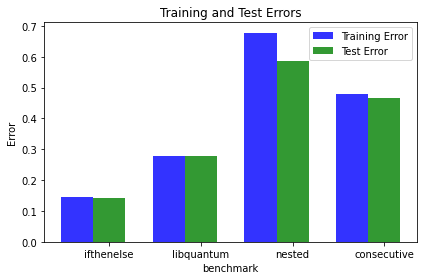

In [ ]:
weights = []
training_errors = []
test_errors = []

for datafile in (ifthenelse_filepath, libquantum_filepath, nested_filepath, consecutive_filepath):
    features, labels = f.generateTraceFeatures(datafile, history_length, num_of_classes)
    #print ("Features: ", features.shape, " Labels: ", labels.shape)

    indices = np.arange(features.shape[0])
    np.random.shuffle(indices)
    features = features[indices]
    labels = labels[indices]
    labels = labels[indices].reshape(-1,1)
    encoder = OneHotEncoder(sparse=False)
    encoder.fit(labels)
    training_dataset = features[:int(len(features)*0.05)]
    _, num_of_features = training_dataset.shape
    training_labels = labels[:int(len(labels)*0.05)]
    val_dataset = features[int(len(features)*0.05):int(len(features)*0.1)]
    val_labels = labels[int(len(labels)*0.05):int(len(features)*0.1)]
    test_dataset = features[int(len(features)*0.1):]
    test_labels = labels[int(len(labels)*0.1):]
    training_labels = encoder.transform(training_labels)
    val_labels = encoder.transform(val_labels)
    test_labels = encoder.transform(test_labels)
    _, num_of_features = training_dataset.shape
    params={"lr":0.0001,
       "dropout":0.2,
       "N hidden":5,
       "Mini-batch size":32,
        "lrd":0.0001,
        "layers":2
    }
    
    model = create_model(params,num_of_features,"categorical_crossentropy",np.unique(labels).shape[0])
    es=keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=3,min_delta=0.05)
    history = model.fit(training_dataset,training_labels,validation_data=(val_dataset,val_labels),epochs=100,batch_size=params["Mini-batch size"],callbacks=[es], verbose=2)
    
    score = model.evaluate(test_dataset, test_labels, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    training_accuracy=history.history['accuracy'][-1]
    training_errors.append(1-training_accuracy)
    test_errors.append(1-score[1])

fig, ax = plt.subplots()
index = np.arange(4)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, training_errors, bar_width,
                    alpha=opacity,
                    color='b',
                    label='Training Error')

rects2 = plt.bar(index + bar_width, test_errors, bar_width,
                    alpha=opacity,
                    color='g',
                    label='Test Error')

plt.xlabel('benchmark')
plt.ylabel('Error')
plt.title('Training and Test Errors')
plt.xticks(index + bar_width, ('ifthenelse', 'libquantum', 'nested', 'consecutive'))
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/100
782/782 - 3s - loss: 0.6630 - accuracy: 0.8317 - val_loss: 0.6322 - val_accuracy: 0.8579 - 3s/epoch - 3ms/step
Epoch 2/100
782/782 - 2s - loss: 0.6020 - accuracy: 0.8586 - val_loss: 0.5732 - val_accuracy: 0.8579 - 2s/epoch - 2ms/step
Epoch 3/100
782/782 - 2s - loss: 0.5470 - accuracy: 0.8586 - val_loss: 0.5178 - val_accuracy: 0.8579 - 2s/epoch - 2ms/step
Epoch 4/100
782/782 - 2s - loss: 0.4836 - accuracy: 0.8586 - val_loss: 0.4479 - val_accuracy: 0.8579 - 2s/epoch - 2ms/step
Epoch 4: early stopping
Test loss: 0.44890424609184265
Test accuracy: 0.8570207357406616
Epoch 1/100
782/782 - 3s - loss: 0.5336 - accuracy: 0.8550 - val_loss: 0.4448 - val_accuracy: 0.8581 - 3s/epoch - 4ms/step
Epoch 2/100
782/782 - 2s - loss: 0.4771 - accuracy: 0.8605 - val_loss: 0.4244 - val_accuracy: 0.8581 - 2s/epoch - 2ms/step
Epoch 3/100
782/782 - 2s - loss: 0.4610 - accuracy: 0.8605 - val_loss: 0.4217 - val_accuracy: 0.8581 - 2s/epoch - 3ms/step
Epoch 4/100
782/782 - 2s - loss: 0.4510 - accuracy

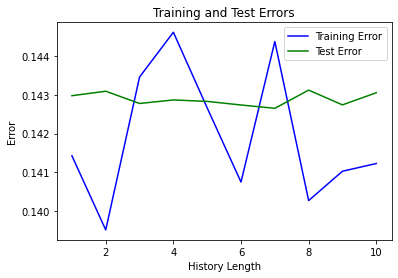

Epoch 1/100
782/782 - 3s - loss: 1.0808 - accuracy: 0.5323 - val_loss: 1.0029 - val_accuracy: 0.7257 - 3s/epoch - 4ms/step
Epoch 2/100
782/782 - 2s - loss: 0.9629 - accuracy: 0.7232 - val_loss: 0.9109 - val_accuracy: 0.7257 - 2s/epoch - 3ms/step
Epoch 3/100
782/782 - 2s - loss: 0.8974 - accuracy: 0.7232 - val_loss: 0.8455 - val_accuracy: 0.7257 - 2s/epoch - 2ms/step
Epoch 4/100
782/782 - 2s - loss: 0.8545 - accuracy: 0.7232 - val_loss: 0.8101 - val_accuracy: 0.7257 - 2s/epoch - 3ms/step
Epoch 4: early stopping
Test loss: 0.8143238425254822
Test accuracy: 0.722777783870697
Epoch 1/100
782/782 - 3s - loss: 0.9648 - accuracy: 0.6203 - val_loss: 0.8170 - val_accuracy: 0.7258 - 3s/epoch - 4ms/step
Epoch 2/100
782/782 - 2s - loss: 0.8378 - accuracy: 0.7097 - val_loss: 0.7834 - val_accuracy: 0.7258 - 2s/epoch - 3ms/step
Epoch 3/100
782/782 - 2s - loss: 0.8228 - accuracy: 0.7233 - val_loss: 0.7783 - val_accuracy: 0.7258 - 2s/epoch - 2ms/step
Epoch 4/100
782/782 - 2s - loss: 0.8121 - accuracy: 

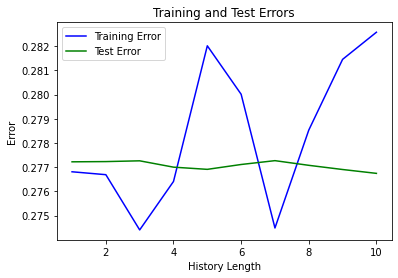

Epoch 1/100
782/782 - 3s - loss: 2.3756 - accuracy: 0.3348 - val_loss: 2.2653 - val_accuracy: 0.4127 - 3s/epoch - 4ms/step
Epoch 2/100
782/782 - 2s - loss: 2.1811 - accuracy: 0.3963 - val_loss: 2.0623 - val_accuracy: 0.4127 - 2s/epoch - 3ms/step
Epoch 3/100
782/782 - 2s - loss: 2.0492 - accuracy: 0.4002 - val_loss: 1.9575 - val_accuracy: 0.4127 - 2s/epoch - 2ms/step
Epoch 4/100
782/782 - 2s - loss: 1.9910 - accuracy: 0.3990 - val_loss: 1.9109 - val_accuracy: 0.4127 - 2s/epoch - 2ms/step
Epoch 4: early stopping
Test loss: 1.9053173065185547
Test accuracy: 0.41468754410743713
Epoch 1/100
782/782 - 3s - loss: 2.4076 - accuracy: 0.3617 - val_loss: 2.3229 - val_accuracy: 0.4107 - 3s/epoch - 4ms/step
Epoch 2/100
782/782 - 2s - loss: 2.2186 - accuracy: 0.4033 - val_loss: 2.0891 - val_accuracy: 0.4107 - 2s/epoch - 3ms/step
Epoch 3/100
782/782 - 2s - loss: 2.0501 - accuracy: 0.4013 - val_loss: 1.9462 - val_accuracy: 0.4107 - 2s/epoch - 2ms/step
Epoch 4/100
782/782 - 2s - loss: 1.9719 - accuracy

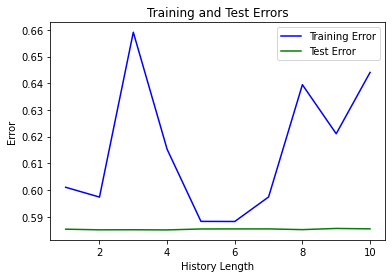

Epoch 1/100
782/782 - 3s - loss: 1.3139 - accuracy: 0.3861 - val_loss: 1.2318 - val_accuracy: 0.5313 - 3s/epoch - 4ms/step
Epoch 2/100
782/782 - 2s - loss: 1.2094 - accuracy: 0.5111 - val_loss: 1.1656 - val_accuracy: 0.5313 - 2s/epoch - 2ms/step
Epoch 3/100
782/782 - 2s - loss: 1.1840 - accuracy: 0.5118 - val_loss: 1.1522 - val_accuracy: 0.5313 - 2s/epoch - 2ms/step
Epoch 4/100
782/782 - 2s - loss: 1.1760 - accuracy: 0.5205 - val_loss: 1.1476 - val_accuracy: 0.5313 - 2s/epoch - 2ms/step
Epoch 4: early stopping
Test loss: 1.146296739578247
Test accuracy: 0.5324742197990417
Epoch 1/100
782/782 - 3s - loss: 1.3450 - accuracy: 0.5167 - val_loss: 1.3048 - val_accuracy: 0.5323 - 3s/epoch - 4ms/step
Epoch 2/100
782/782 - 2s - loss: 1.2735 - accuracy: 0.5223 - val_loss: 1.2319 - val_accuracy: 0.5323 - 2s/epoch - 3ms/step
Epoch 3/100
782/782 - 2s - loss: 1.2155 - accuracy: 0.5226 - val_loss: 1.1826 - val_accuracy: 0.5323 - 2s/epoch - 3ms/step
Epoch 4/100
782/782 - 2s - loss: 1.1861 - accuracy: 

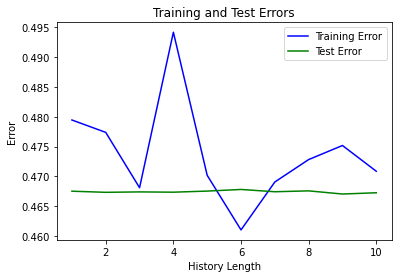

In [ ]:
for filepath in (ifthenelse_filepath, libquantum_filepath, nested_filepath, consecutive_filepath):
    training_errors = []
    test_errors = []
    for history_length in (1, 2, 3, 4, 5, 6, 7, 8, 9, 10):
        features, labels = f.generateTraceFeatures(filepath, history_length, num_of_classes)
        #print ("Features: ", features.shape, " Labels: ", labels.shape)

        indices = np.arange(features.shape[0])
        np.random.shuffle(indices)
        features = features[indices]
        labels = labels[indices]

        encoder = OneHotEncoder(sparse=False)
        labels = labels[indices].reshape(-1,1)
        encoder.fit(labels)
        training_dataset = features[:int(len(features)*0.05)]
        _, num_of_features = training_dataset.shape
        training_labels = labels[:int(len(labels)*0.05)]
        val_dataset = features[int(len(features)*0.05):int(len(features)*0.1)]
        val_labels = labels[int(len(labels)*0.05):int(len(features)*0.1)]
        test_dataset = features[int(len(features)*0.1):]
        test_labels = labels[int(len(labels)*0.1):]
        training_labels = encoder.transform(training_labels)
        val_labels = encoder.transform(val_labels)
        test_labels = encoder.transform(test_labels)
        _, num_of_features = training_dataset.shape
        params={"lr":0.0001,
          "dropout":0.2,
          "N hidden":5,
          "Mini-batch size":32,
            "lrd":0.0001,
            "layers":2
        }
        
        model = create_model(params,num_of_features,"categorical_crossentropy",np.unique(labels).shape[0])
        es=keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=3,min_delta=0.05)
        history = model.fit(training_dataset,training_labels,validation_data=(val_dataset,val_labels),epochs=100,batch_size=params["Mini-batch size"],callbacks=[es], verbose=2)
        
        score = model.evaluate(test_dataset, test_labels, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        training_accuracy=history.history['accuracy'][-1]
        training_errors.append(1-training_accuracy)
        test_errors.append(1-score[1])

    # plot the training and test errors (scatter plot)
    fig, ax = plt.subplots()
    ax.plot(np.arange(1, 11), training_errors, color='b', label='Training Error')
    ax.plot(np.arange(1, 11), test_errors, color='g', label='Test Error')
    ax.set_xlabel('History Length')
    ax.set_ylabel('Error')
    ax.set_title('Training and Test Errors')
    ax.legend()
    plt.show()
    
